In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
plt.style.use('dark_background')

In [8]:
df = pd.read_csv('AirPassengers.csv')
print(df.dtypes)

Month         object
Passengers     int64
dtype: object


In [9]:
df['Month'] = pd.to_datetime(df['Month'])
print(df.dtypes)

Month         datetime64[ns]
Passengers             int64
dtype: object


In [10]:
df

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [11]:
df.set_index('Month', inplace=True)

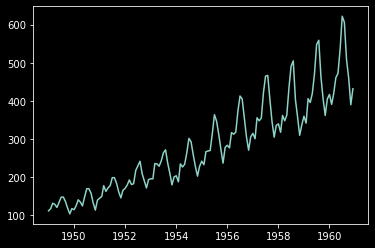

In [12]:
plt.plot(df['Passengers'])

In [14]:
from pmdarima.arima import ADFTest

In [15]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df)
#Not stationary...

(0.01, False)

In [16]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")
#Since data is not stationary, we may need SARIMA and not just ARIMA

pvalue =  0.991880243437641  if above 0.05, data is not stationary


In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(df['Passengers'],  
                            model ='additive')

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid


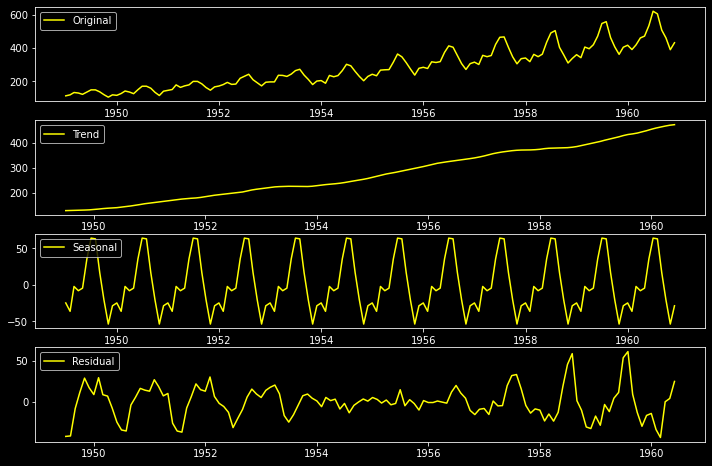

In [18]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df, label='Original', color='yellow')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='yellow')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='yellow')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='yellow')
plt.legend(loc='upper left')
plt.show()

In [19]:
from pmdarima.arima import auto_arima

In [20]:
#Autoarima gives us bet model suited for the data
# p - number of autoregressive terms (AR)
# q - Number of moving avergae terms (MA)
# d - number of non-seasonal differences
#p, d, q represent non-seasonal components
#P, D, Q represent seasonal components

In [22]:
arima_model = auto_arima(df['Passengers'], start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=100)        

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.04 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.12 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1020.582, Time=0.25 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.16 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.03 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.11 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.15 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.23 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.13 sec
 ARIMA(0,1,1)(1,1,0)[12]     

In [23]:
print(arima_model.summary() )

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Sat, 03 Jun 2023   AIC                           1019.178
Time:                                     18:11:15   BIC                           1030.679
Sample:                                 01-01-1949   HQIC                          1023.851
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      

In [24]:
# Model: SARIMAX(0, 1, 1)x(2, 1, [], 12)

In [25]:
#Split data into train and test
size = int(len(df) * 0.66)
X_train, X_test = df[0:size], df[size:len(df)]

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

In [30]:
model = SARIMAX(X_train['Passengers'],  
                order = (0, 1, 1),  
                seasonal_order =(2, 1, 1, 12)) 

C:\Users\jpolo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\jpolo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [31]:
result = model.fit() 
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                   95
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -300.269
Date:                            Sat, 03 Jun 2023   AIC                            610.538
Time:                                    18:15:55   BIC                            622.572
Sample:                                01-01-1949   HQIC                           615.370
                                     - 11-01-1956                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3203      0.102     -3.148      0.002      -0.520      -0.121
ar.S.L12       0.6848      0.639      1.071      0.284      -0.568       1.937
ar.S.L24       0.3138      0.133      2.356      0.018       0.053       0.575
ma.S.L12      -0.9791      5.241     -0.187      0.852     -11.252       9.294
sigma2        78.7155    362.806      0.217      0.828    -632.372     789.803
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.56
Prob(Q):                              0.95   Prob(JB):                         0.28
Heteroskedasticity (H):               1.68   Skew:                             0.42
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:

#Prediction
start_index = len(X_train)
end_index = len(df)-1
prediction = result.predict(start_index, end_index).rename('Predicted passengers') 

<AxesSubplot:xlabel='Month'>

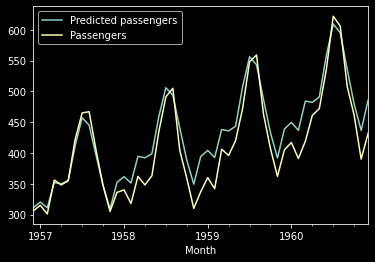

In [36]:
prediction.plot(legend = True) 
X_test['Passengers'].plot(legend = True)

In [37]:
import math
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(X_train, train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(X_test, prediction))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 16.14 RMSE
Test Score: 29.50 RMSE


In [38]:
from sklearn.metrics import r2_score
score = r2_score(X_test, prediction)
print("R2 score is: ", score)

R2 score is:  0.8582889356679687


In [39]:
forecast = result.predict(start = len(df),  
                          end = (len(df)-1) + 3 * 12,  
                          typ = 'levels').rename('Forecast')

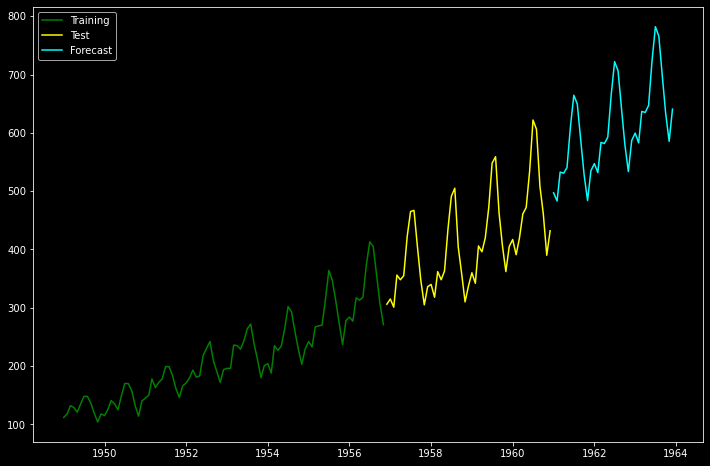

In [41]:
plt.figure(figsize=(12,8))
plt.plot(X_train, label='Training', color='green')
plt.plot(X_test, label='Test', color='yellow')
plt.plot(forecast, label='Forecast', color='cyan')
plt.legend(loc='upper left')
plt.show()